In [1]:
import requests
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as statis
import scipy
import sklearn
from sklearn import linear_model
from sklearn import kernel_ridge
import json
pd.set_option('display.max_rows', 10000)  # 显示的最大行数（避免只显示部分行数据）
pd.set_option('display.max_columns', 1000)  # 显示的最大列数（避免列显示不全）
pd.set_option("display.max_colwidth", 1000)  # 每一列最大的宽度（避免属性值或列名显示不全）
pd.set_option('display.width', 1000)  # 每一行的宽度（避免换行）

headers = {'User-Agent':'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36 QIHU 360SE'}
srcurl = 'https://3g.dxy.cn/newh5/view/pneumonia?scene=2&clicktime=1579582238&enterid=1579582238&from=singlemessage&isappinstalled=0'

def gethtml(url):
    global headers, srcurl
    page = requests.get(url, headers=headers)
    page.encoding = 'utf-8'
    return page.text


In [2]:
html = gethtml(srcurl)

ConnectionError: HTTPSConnectionPool(host='3g.dxy.cn', port=443): Max retries exceeded with url: /newh5/view/pneumonia?scene=2&clicktime=1579582238&enterid=1579582238&from=singlemessage&isappinstalled=0 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fdfb866a3a0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

In [3]:
def getCountry(line):

    Countrydata = re.findall('getListByCountryTypeService2true = (.*?)}catch\(e\)',line.splitlines()[12])[0]

    clearndata = []
    for string in Countrydata.split('},{'):
        clearning1 = string.replace("[{","").replace('{','').replace('}','')
        name = [[j.replace('"','') for j in i.split(':')][0] for i in clearning1.split(',')]
        data = [[j.replace('"', '') for j in i.split(':')][-1] for i in clearning1.split(',')]
        clearndata.append({i:j for i,j in zip(name,data)})

    statisticsData_List = []
    continents_List = []
    provinceName_List = []

    for i in clearndata:
        for name, data in i.items():
            data = data.replace(']',"")
            if "statisticsData" in name:
                statisticsData_List.append(data)
            elif "continents" in name:
                continents_List.append(data)
            elif "provinceName" in name:
                provinceName_List.append(data)
    dict_= {'continents':continents_List,'provinceName':provinceName_List,'url':statisticsData_List}
    return dict_

In [4]:
statistics_urls = getCountry(html)

In [5]:
def one_county(name):
    data_dict = {name : data for name , data in zip(statistics_urls['provinceName'],statistics_urls['url'])}
    return data_dict[name]
    
one_county('美国')

'//file1.dxycdn.com/2020/0315/553/3402160512808052518-135.json'

In [6]:
def get_data(name):
    url = 'https:'+one_county(name)
    print(url)
    Js = json.loads(requests.get(url).text)['data']
    name = ["".join(re.findall('dict_keys\(\[(.*?)\]\)',str(i.keys()))).split(',') for i in Js][0]
    data = [(list(map(lambda x : int(x) ,"".join(re.findall('dict_values\(\[(.*?)\]\)',str(i.values()))).replace(' ','').split(',')))) for i in Js]
    return {'columnName':[{num:name}for num,name in zip(range(len(name)),name)],'data':np.mat(data)}

In [7]:
country_name = np.array(statistics_urls['provinceName'])

In [8]:
def to_table(name):
    data = get_data(name)
    column = [data['columnName'][i][i].replace(" '",'').replace("'",'') for i in range(len(data['columnName']))]
    rows = [np.squeeze(np.array(data['data'][:,i])) for i in range(len(data['columnName']))]
    return pd.DataFrame({name : data for name , data in  zip(column,rows)})

https://file1.dxycdn.com/2020/0315/963/3402160508513085001-135.json


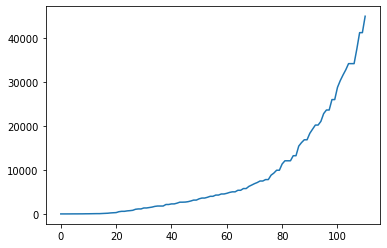

In [9]:
plt.plot(to_table("阿根廷").confirmedCount)

In [10]:
USA = to_table('美国')

https://file1.dxycdn.com/2020/0315/553/3402160512808052518-135.json


In [22]:
USA.deadCount/USA.currentConfirmedCount

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      0.000000
8      0.000000
9      0.000000
10     0.000000
11     0.000000
12     0.000000
13     0.000000
14     0.000000
15     0.000000
16     0.000000
17     0.000000
18     0.000000
19     0.000000
20     0.000000
21     0.000000
22     0.000000
23     0.000000
24     0.000000
25     0.000000
26     0.000000
27     0.000000
28     0.000000
29     0.000000
30     0.000000
31     0.000000
32     0.000000
33     0.000000
34     0.000000
35     0.000000
36     0.000000
37     0.000000
38     0.000000
39     0.000000
40     0.032258
41     0.058824
42     0.075000
43     0.072464
44     0.054455
45     0.054455
46     0.054455
47     0.041943
48     0.037258
49     0.030271
50     0.029316
51     0.023666
52     0.021630
53     0.019546
54     0.020040
55     0.017068
56     0.015393
57     0.013023
58     0.012030
59     0.012590
60     0.012540
61     0.013377
62     0

In [11]:
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def logistic_model(x,a,b,c):
    '''
    a为感染速度
    b为感染发生最多的一天
    c是在感染结束时记录的感染者总数
    '''
    return c/(1+np.exp(-(x-b)/a))

len_ = USA.confirmedCount.values.shape[0]
x = list(range(len_))
y = list(USA.confirmedCount)
fit = curve_fit(logistic_model,x,y,p0=[2,100,20000])
a,b,c= tuple(fit[0])

In [13]:
{"感染速度":a,"感染最多的一天":b}

{'感染速度': -333803756.82310826, '感染最多的一天': 30917052.541765727}

In [14]:
def logistic_model1(data):
    '''
    a为速度
    b数量的极大值
    c预期最终总数
    '''
    data = [i for i in data ]
    from scipy.optimize import curve_fit
    len_ = len(data)
    x = list(range(len_))
    y = list(data)
    funtion = lambda a,b,c,x : c/(1+np.exp(-(x-b)/a))
    fit = curve_fit(logistic_model,x,y,p0=[2,100,200000])
    a,b,c= tuple(fit[0])
    logistic_number = funtion(a,b,c,x)
    return (a,b,c,x,y,fit[1],logistic_number)

In [15]:
a,b,c,x,y,fit1,logistic_number = logistic_model1(USA.confirmedCount)

In [16]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
print("预测最终感染人数:",c-errors[-1])
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
print("当前模型预计结束于",sol-x[-1])

预测最终感染人数: -856993300786.1844
当前模型预计结束于 201


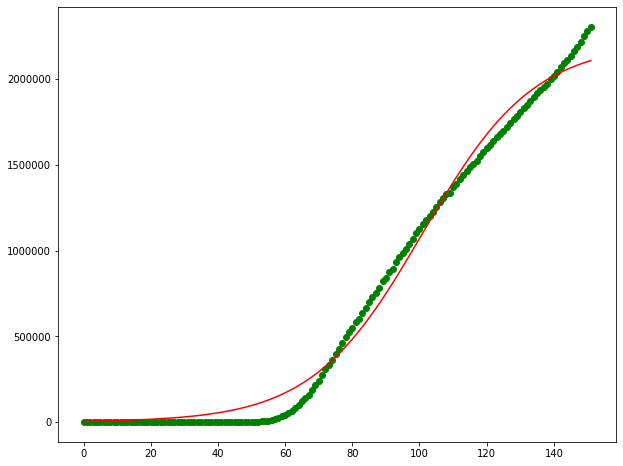

In [17]:
plt.figure(figsize=(10,8))
plt.scatter(x,y,c='g')
plt.plot(logistic_number,c='r')

date = list(USA.dateId)
plt.figure(figsize=(16,9))
logistic_number = logistic_model(x,a,b,c)
plt.plot(logistic_number,c='r')
plt.scatter(x,y)
plt.xticks(x,date,rotation='vertical')

In [18]:
from json import loads

def translate(word):
    # 有道词典 api
    url = 'http://fanyi.youdao.com/translate?smartresult=dict&smartresult=rule&smartresult=ugc&sessionFrom=null'
    # 传输的参数，其中 i 为需要翻译的内容
    key = {
        'type': "AUTO",
        'i': word,
        "doctype": "json",
        "version": "2.1",
        "keyfrom": "fanyi.web",
        "ue": "UTF-8",
        "action": "FY_BY_CLICKBUTTON",
        "typoResult": "true"
    }
    # key 这个字典为发送给有道词典服务器的内容
    response = requests.post(url, data=key)
    # 判断服务器是否相应成功
    if response.status_code == 200:
        # 然后相应的结果
        return loads(response.text)['translateResult'][0][0]['tgt']
    else:
        print("有道词典调用失败")
        # 相应失败就返回空
        return None


def plot_logistic_model(other_name):
    __import__('os').system('say 正在构建'+other_name+'的逻辑斯蒂模型，请稍后')
    logistic_model = lambda x,a,b,c : c/(1+np.exp(-(x-b)/a))
    '''
    a为感染速度
    b为感染发生最多的一天
    c是在感染结束时记录的感染者总数
    '''
    example = to_table(other_name)

    len_ = example.confirmedCount.values.shape[0]
    x = list(range(len_))
    y = list(example.confirmedCount)
    fit = curve_fit(logistic_model,x,y,p0=[2,100,20000])
    a,b,c= tuple(fit[0])
    sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))


    date = list(example.dateId)
    plt.figure(figsize=(16,6))
    logistic_number = logistic_model(x,a,b,c)
    plt.plot(logistic_number,c='r')
    plt.plot(np.gradient(y)*10,c='g')
    plt.scatter(x,y)
    plt.xticks(x,date,rotation='vertical')
    plt.title(translate(other_name))

    
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    results = {"感染速度":a,"感染最多的一天":b,"预测最终感染人数":c-errors[-1],'预计剩余结束天数':sol-x[-1]}
    __import__('os').system('say'+" 感染速度为"+str(a)+"感染最多的一天是第"+str(int(b))+"天，预测最终感染人数为"+str(int(c-errors[-1]))+'人'+',预计剩余结束天数为'+str(sol-x[-1])+'天')
    return results,example

https://file1.dxycdn.com/2020/0315/629/3402160517102843039-135.json


            2              0           0          0                      2                     0  20200227          0         0               0                   0
 27                2              0           0          0                      2                     0  20200228          0         0               0                   0
 28                2              0           0          0                      2                     0  20200229          0         0               0                   0
 29                2              0           0          0                      2                     0  20200301          0         0               0                   0
 30                2              0           0          0                      2                     0  20200302          0         0               0                   0
 31                3              1           0          0                      3                     1  20200303          0         0               0  

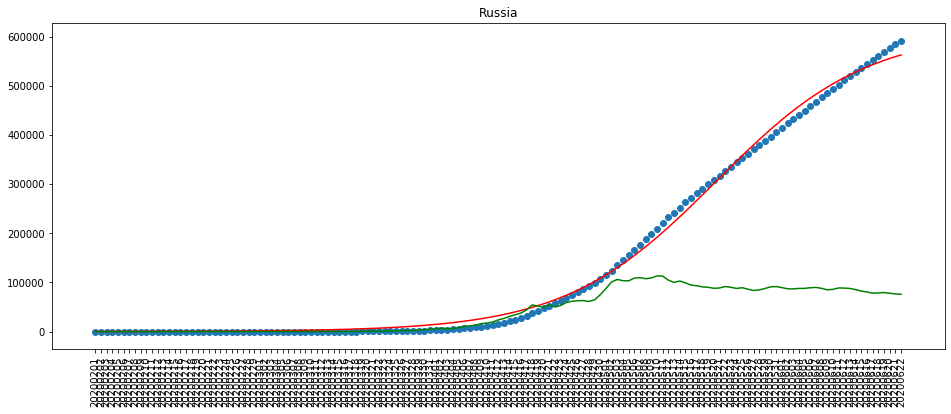

In [19]:
plot_logistic_model("俄罗斯")